In [40]:
import pandas
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

df = pandas.read_feather('data_dump.bin')



In [2]:
df

,x,y,z
0,0.072,-0.048,-0.856
1,0.072,0.000,-0.848
2,0.032,0.000,-0.848
3,0.128,-0.120,-0.984
4,0.048,-0.032,-0.840
...,...,...,...
44760,0.120,0.016,-0.776
44761,0.088,-0.056,-0.760
44762,0.168,-0.024,-0.736
44763,0.056,0.280,-1.000


In [3]:
df.describe()

,x,y,z
count,44765.000000,44765.000000,44765.000000
mean,0.090017,-0.022997,-0.867976
std,0.035953,0.038861,0.090954
min,0.000000,-0.176000,-1.240000
25%,0.064000,-0.048000,-0.888000
50%,0.080000,-0.016000,-0.856000
75%,0.112000,0.000000,-0.832000
max,0.280000,0.280000,-0.584000


In [4]:
# Remove gravity
df['z'] += 1

In [5]:
df.describe()

,x,y,z
count,44765.000000,44765.000000,44765.000000
mean,0.090017,-0.022997,0.132024
std,0.035953,0.038861,0.090954
min,0.000000,-0.176000,-0.240000
25%,0.064000,-0.048000,0.112000
50%,0.080000,-0.016000,0.144000
75%,0.112000,0.000000,0.168000
max,0.280000,0.280000,0.416000


<AxesSubplot:ylabel='Frequency'>

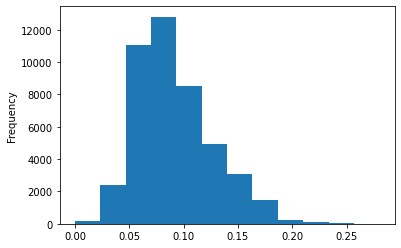

In [30]:
df['x'].plot.hist(bins=12)

In [7]:
df['x'].std()

0.035953337284718785

In [8]:
df.plot.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['x'], df['y'], df['z'])

In [ ]:
import scipy as sp
x_dps = np.array(df['x'])
x_fft = sp.fftpack.fft(x_dps)

x_psd = np.abs(x_fft) ** 2
x_fftfreq = sp.fftpack.fftfreq(len(x_psd))

i = x_fftfreq > 0

#ax = fig.add_subplot()
plt.plot(x_fftfreq[i], 10 * np.log10(x_psd[i]))
#ax.set_ylabel('PSD (dB)')
#plt.show()

In [15]:
# Obtain a second dataframe that doesn't remove gravity so we can perform angle analysis as well
df_with_g = pandas.read_feather('data_dump.bin')

In [18]:

rot_x_dps = np.arctan2(df_with_g['x'], np.hypot(df_with_g['y'], df_with_g['z']))
avg_rot_x = np.average(rot_x_dps)

rot_y_dps = np.arctan2(df_with_g['y'], np.hypot(df_with_g['x'], df_with_g['z']))
avg_rot_y = np.average(rot_y_dps)


pitch = avg_rot_y
roll = avg_rot_x

print(f"Average Pitch: {np.rad2deg(pitch)}")
print(f"Average Roll: {np.rad2deg(roll)}")




Average Pitch: -1.3657101769069224
Average Roll: 5.886719863491827


In [88]:
def get_rotation_matrix(yaw, pitch, roll):
    return np.array([
        [np.cos(roll) * np.cos(pitch), np.cos(pitch) * np.sin(roll), -np.sin(pitch)],
        [np.cos(roll) * np.sin(yaw) * np.sin(pitch) - np.cos(yaw) * np.sin(roll),
         np.cos(yaw) * np.cos(roll) + np.sin(yaw) * np.sin(roll) * np.sin(pitch), np.cos(pitch) * np.sin(yaw)],
        [np.sin(yaw) * np.sin(roll) + np.cos(yaw) * np.cos(roll) * np.sin(pitch),
         np.cos(yaw) * np.sin(roll) * np.sin(pitch) - np.cos(roll) * np.sin(yaw), np.cos(yaw) * np.cos(pitch)]])


# Attempt to remove rotation from the dataframe
rot_removed_df = df @ get_rotation_matrix(0, -pitch, -roll)
rot_removed_df.columns = ['x', 'y', 'z']


print(f"original: {df.describe()}\n\nrot_removed: {rot_removed_df.describe()}")


original:                   x             y             z
count  44765.000000  44765.000000  44765.000000
mean       0.090017     -0.022997     -0.867976
std        0.035953      0.038861      0.090954
min        0.000000     -0.176000     -1.240000
25%        0.064000     -0.048000     -0.888000
50%        0.080000     -0.016000     -0.856000
75%        0.112000      0.000000     -0.832000
max        0.280000      0.280000     -0.584000

rot_removed:                   x             y             z
count  44765.000000  44765.000000  44765.000000
mean       0.066580     -0.029984     -0.869875
std        0.033628      0.040257      0.091235
min       -0.034123     -0.185771     -1.243080
25%        0.043540     -0.055165     -0.890417
50%        0.061661     -0.019604     -0.858617
75%        0.084076     -0.002849     -0.832908
max        0.241983      0.275226     -0.585931


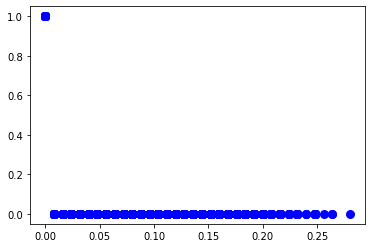

In [89]:
# Plot histogram/distribution and compare to poisson distribution
# NOTE: NOt really working / lacking significant knowledge about the distribution
#df['x'].plot.hist(bins=12)
mu_x = np.average(df['x'])
plt.plot(df['x'], stats.poisson.pmf(df['x'], 0), 'bo', ms=8, label='poisson pmf')

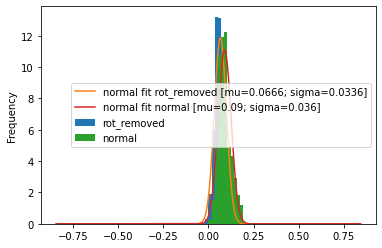

In [95]:
# Plot histograms to compare the effects of removing noise
def plot_hist(df_to_use, name=''):
    df_to_use['x'].plot.hist(bins=16, density=True, label=name)
    mu = np.average(df_to_use['x'])
    sigma = np.std(df_to_use['x'])

    #x = np.linspace(stats.norm.ppf(0.01),
    #                stats.norm.ppf(0.99), 1000)
    x = np.linspace(stats.norm.ppf(0.2),
                    stats.norm.ppf(0.8), 10000)

    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=f'normal fit {name} [mu={mu:.3}; sigma={sigma:.3}]')

plot_hist(rot_removed_df, 'rot_removed')
plot_hist(df, 'normal')
plt.legend()

In [69]:
import matplotlib
print('matplotlib: {}'. format(matplotlib. __version__))

matplotlib: 3.4.2


In [101]:
# Compute new gain to get averages on the 0
new_gain = np.average(rot_removed_df + np.array([0, 0, 1]), 0)
new_gain

array([ 0.06657998, -0.02998412,  0.13012461])

In [104]:
# Remove gravity and compensate for the new gain
df_with_new_gain = rot_removed_df + np.array([0, 0, 1]) - new_gain
df_with_new_gain.describe()

,x,y,z
count,4.476500e+04,4.476500e+04,4.476500e+04
mean,3.466604e-16,-4.295161e-16,3.383272e-15
std,3.362799e-02,4.025737e-02,9.123504e-02
min,-1.007031e-01,-1.557871e-01,-3.732044e-01
25%,-2.304012e-02,-2.518101e-02,-2.054175e-02
50%,-4.919022e-03,1.038000e-02,1.125848e-02
75%,1.749633e-02,2.713544e-02,3.696771e-02
max,1.754034e-01,3.052102e-01,2.839439e-01


In [106]:
np.array(df_with_new_gain.std())

array([0.03362799, 0.04025737, 0.09123504])